# PREDICTION TASK 1 (Using the Daily Data)

Here we simply regress the input data on the Incident_Rate label using the daily data. The features are Province_State, Population, Elapsed_Days and Percentage_Home. Just to recap, the label here is the Incident Rate, which is the ratio of case/ 100000 People. Also we only take the rows where the Incident Rate is greater than 0.5.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import sklearn.model_selection as CrossValidate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib.pyplot import rcParams


plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.callbacks import EarlyStopping

import statsmodels.api as sm


print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
tf.keras.backend.set_floatx('float64')


TensorFlow version: 2.1.0
Eager execution: True


In [2]:
#standardizer function which standardizes the numerical data and encodes the categorical data with LabelEncoder
def standardize_fit1 (Xin):
    #standadizing the numercial values
    scaler = StandardScaler()
    X = Xin.values[:,1:]
    scaler.fit(X)

    #standadizing the categorical values
    encoder = LabelEncoder()
    X = Xin.values[:,0].reshape(-1, 1)
    encoder.fit(X)
    classes= encoder.classes_

    return classes, scaler, encoder 

def standardize_transfrom1( Xin, scaler, encoder):
    X = Xin.values[:,1:]
    X_std_num = np.asarray(scaler.transform(X)).astype(np.float64)
    X = Xin.values[:,0].reshape(-1, 1)
    X_std_cat =  encoder.transform(X).reshape(-1, 1)
    return np.concatenate((X_std_cat, X_std_num),axis=1)

In [3]:
#standardizer function which standardizes the numerical data and encodes the categorical data with One hot encoding
def standardize_fit2 (Xin):
    #standadizing the numercial values
    scaler = StandardScaler()
    X = Xin.values[:,1:]
    scaler.fit(X)

    #standadizing the categorical values
    encoder = OneHotEncoder(sparse=False)
    X = Xin.values[:,0].reshape(-1, 1)
    encoder.fit(X)
    categories= encoder.categories_

    return categories, scaler, encoder 

def standardize_transfrom2( Xin, scaler, encoder):
    X = Xin.values[:,1:]
    X_std_num = np.asarray(scaler.transform(X)).astype(np.float64)
    X = Xin.values[:,0].reshape(-1, 1)
    X_std_cat =  encoder.transform(X)
    return np.concatenate((X_std_cat, X_std_num),axis=1)

In [4]:
# K-fold cross validation 
def CrossValKF (model, X , K = 10):
    n,_ = X.shape
    kf = CrossValidate.KFold(shuffle=False, n_splits = K)
    absolute_errorsList = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        error = mean_absolute_error(y_true= y_val, y_pred= y_pred)
        absolute_errorsList.append(error)
    return np.mean(absolute_errorsList)

In [5]:
# cross validation with Leave one out
def CrossValLOO (model, X):
    loo = CrossValidate.LeaveOneOut()
    absolute_errorsList = []
    for train_index, val_index in loo.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train,y_train)
        y_pred = model.predict(X_val)
        error = mean_absolute_error(y_true= y_val, y_pred= y_pred)
        absolute_errorsList.append(error)
    return np.mean(absolute_errorsList)

In [6]:
#importing the train set
X_tr = pd.read_csv('../data/X_daily_tr.csv')   
y_tr = pd.read_csv('../data/y_daily_tr.csv') 

In [7]:
# just to make sure if any Null is left
print ("number of nulls left is ", len(X_tr[X_tr.isnull().values == True].head()))

number of nulls left is  0


In [8]:
# only keeping the data where incident rate is more than 0.5
X_tr = X_tr[y_tr['Incident_Rate'] >= 0.5]
y_tr = y_tr[y_tr['Incident_Rate'] >= 0.5]

In [9]:
X_tr.head()

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
157,2020-02-21,Nebraska,1934408.0,0,19.236149
265,2020-03-04,Washington,7614893.0,0,23.675703
282,2020-03-05,Washington,7614893.0,1,24.347069
307,2020-03-06,Washington,7614893.0,2,24.577092
337,2020-03-07,Washington,7614893.0,3,27.524526


In [10]:
# (Explore can we cross validate with splitting by each day?)
train_timestamps = X_tr['Date'].values
train_timestamps[:5]

array(['2020-02-21', '2020-03-04', '2020-03-05', '2020-03-06',
       '2020-03-07'], dtype=object)

In [11]:
X_tr = X_tr.drop(['Date'], axis=1)
y_tr = y_tr.drop(['Date'], axis=1)

In [12]:
X_tr.head()

,Province_State,Population,Elapsed_Days,Percentage_Home
157,Nebraska,1934408.0,0,19.236149
265,Washington,7614893.0,0,23.675703
282,Washington,7614893.0,1,24.347069
307,Washington,7614893.0,2,24.577092
337,Washington,7614893.0,3,27.524526


In [13]:
X_tr.describe()

,Population,Elapsed_Days,Percentage_Home
count,2.920000e+03,2920.000000,2920.000000
mean,6.420689e+06,27.018493,37.653490
std,7.291724e+06,16.636420,6.623412
min,5.787590e+05,0.000000,17.885169
25%,1.787065e+06,13.000000,32.934542
50%,4.467673e+06,27.000000,37.216028
75%,7.614893e+06,41.000000,41.818998
max,3.951222e+07,66.000000,69.594465


In [14]:
# standardizing the training data

categories, scaler, encoder2 = standardize_fit2(X_tr)
X_tr_std = standardize_transfrom2(X_tr, scaler, encoder2)
# using the standardized data with sparse matrix for the categorized data (One hot encoded)

In [15]:
#find the id of california in the categories array (note that categories has only one elemnts and it is the array of categories so we should use categories[0])
calid = np.where(categories[0] == 'California')[0][0]
print("index of California is =", calid)
print(X_tr.head())
print(X_tr_std[:5, calid] == 1)

index of California is = 4
    Province_State  Population  Elapsed_Days  Percentage_Home
157       Nebraska   1934408.0             0        19.236149
265     Washington   7614893.0             0        23.675703
282     Washington   7614893.0             1        24.347069
307     Washington   7614893.0             2        24.577092
337     Washington   7614893.0             3        27.524526
[False False False False False]


Text(0.5, 1.0, ' Number of Days with more than 0.5 Incidence rate for each state in the training data set')

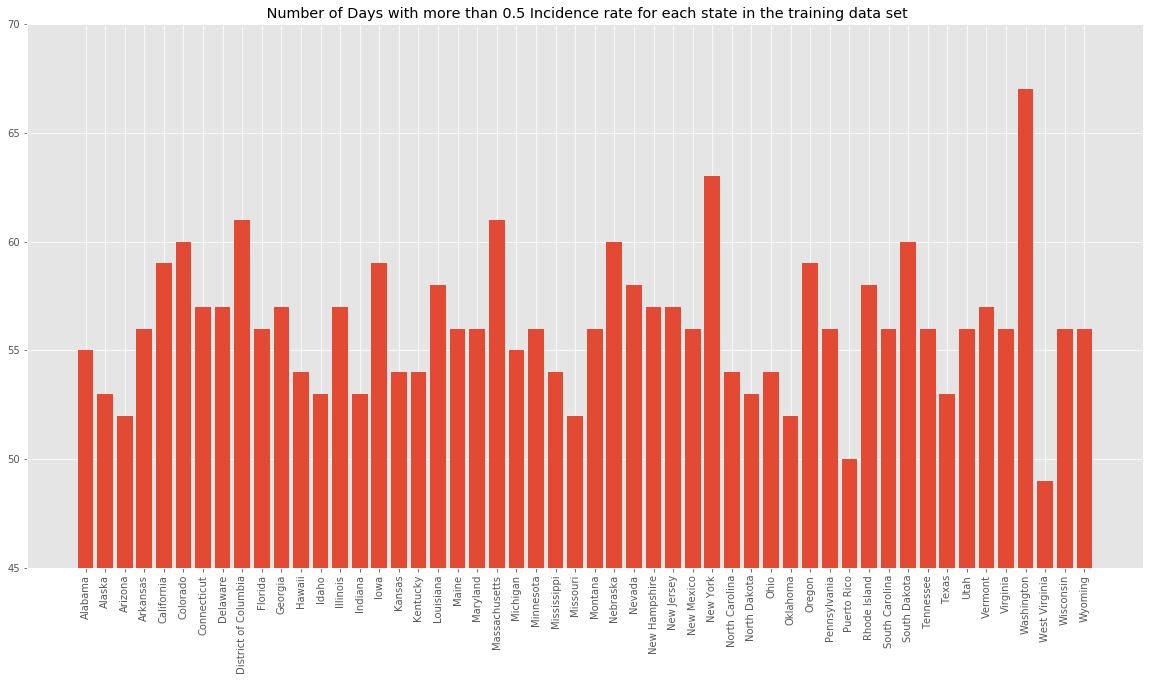

In [16]:
# calculate the total count of datas from each state
DaysWithCases = [sum(X_tr_std[:, x] == 1) for x in range(0,52)]
rcParams['figure.figsize'] = 20,10
plt.bar(categories[0], DaysWithCases)
plt.xticks(categories[0], rotation='vertical')
plt.ylim((45,70))
plt.title(" Number of Days with more than 0.5 Incidence rate for each state in the training data set")

## The data is a bit unbalanced but We hope that by using the one-hot encoding technique, we could aleviate its effect

In [17]:
y_tr.describe()

,Incident_Rate
count,2920.000000
mean,139.077962
std,232.835254
min,0.503619
25%,16.006792
50%,60.191737
75%,145.736850
max,1712.395998


In [18]:
#importing the test set
X_te = pd.read_csv('../data/X_daily_te.csv')   
y_te = pd.read_csv('../data/y_daily_te.csv') 

In [19]:
X_te.tail()

,Date,Province_State,Population,Elapsed_Days,Percentage_Home
775,2020-05-24,Virginia,8535519.0,70,37.320900
776,2020-05-24,Washington,7614893.0,81,39.301188
777,2020-05-24,West Virginia,1792147.0,63,30.168107
778,2020-05-24,Wisconsin,5822434.0,70,32.491617
779,2020-05-24,Wyoming,578759.0,70,34.528039


In [20]:
# only keeping the data where incident rate is more than 0.5
X_te = X_te[y_te['Incident_Rate'] >= 0.5]
y_te = y_te[y_te['Incident_Rate'] >= 0.5]


In [21]:
test_timestamps = X_te['Date'].values
X_te = X_te.drop(['Date'], axis=1)
y_te = y_te.drop(['Date'], axis=1)

In [22]:
#standardizing the test data from the previously fitted standardizers
X_te_std = standardize_transfrom2(X_te, scaler, encoder2)
# using the standardized data with sparse matrix for the categorized data (One hot encoded)

# Designing our regression models

without any delays

1- Random Forests Regression

2- Support Vector Machine Regression 

3- Poisson Regression with Generalized linear model (from statsmodel api)

4- MLP Regression based on the Poisson Loss and Optimized with Adam Optimizer

For this Task we could use the cross validation metrics, but we have to be careful about splitting to multiple folds so as not to make the dataset unbalanced. So instead we are going to evaluate the Mean Absolute Error of the cases for the whole trainign dataset

In [23]:
# creating the dataset
X = X_tr_std
y = y_tr.values

Xt = X_te_std
yt = y_te.values

X = np.asarray(X).astype(np.float64)
y = np.asarray(y).astype(np.float64)
Xt = np.asarray(Xt).astype(np.float64)
yt = np.asarray(yt).astype(np.float64)

_, num_features = X.shape

#number of folds in K-Fold Cross Validation
# CVK = 3

# Random Forest Regressor

In [24]:
params = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [4, 8, 12, 16, 20, 32]
}

best_score = np.Inf
for g in ParameterGrid(params):
    rf = None
    rf = RandomForestRegressor()
    rf.set_params(**g)
    rf.fit(X, y)
    #save the best result with each parameter set
    #With Cross Validation
    # score = CrossValKF(model= rf, X=X, K=CVK)
    # score = CrossValLOO(model= rf, X=X)
    #no cross validation
    y_pred = rf.predict(X)
    score = mean_absolute_error(y_true= y, y_pred= y_pred)
    if score < best_score:
        best_score = score
        best_grid = g

print("Mean Abosulte Error score of the best model: %0.5f" % best_score )
print("best Params:", best_grid)

Mean Abosulte Error score of the best model: 4.21562
best Params: {'max_depth': 32, 'n_estimators': 200}


Mean Abosulte Error score of the best model on the whole test dataset is : 81.87478


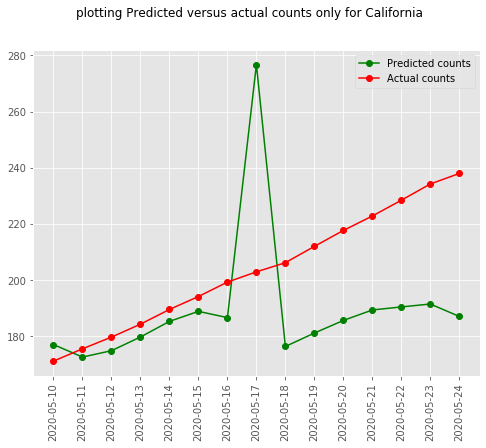

<Figure size 576x432 with 0 Axes>

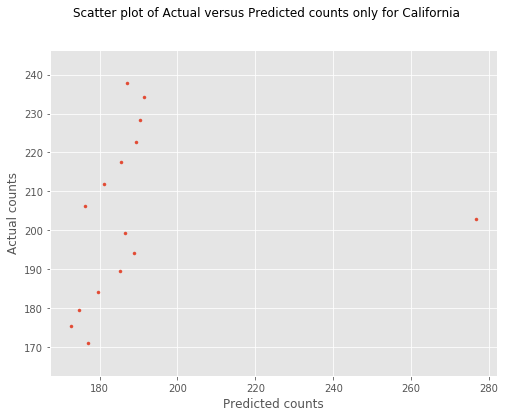

In [25]:
# on the total test dataset we find the MAE
rf.set_params(**best_grid)
rf.fit(X, y)
y_pred_test = rf.predict(Xt)
print("Mean Abosulte Error score of the best model on the whole test dataset is : %0.5f" % mean_absolute_error(y_true= yt, y_pred= y_pred_test) )

#Plot the predicted counts versus the actual counts for the test data for california.
rcParams['figure.figsize'] = 8,6
calidx = [X_te_std[:,calid] == 1 ]
fig = plt.figure()
fig.suptitle('plotting Predicted versus actual counts only for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred_test[calidx], 'go-', label='Predicted counts')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.xticks(test_timestamps[calidx], rotation='vertical')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts only for California')
plt.scatter(x=y_pred_test[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.ylabel('Actual counts')
plt.axis('equal')
plt.show()

### As we can see here, the Mean Absolute error on the whole test dataset seems fine, but the model couldn't capture the trend in the California Cases.

# Support Vector Machine Regressor

In [26]:
params = {
    "C" : [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5],
    "kernel" : ["rbf","poly","sigmoid", "linear"],
    "gamma" : ["scale"]
}

best_score = np.Inf 
for g in ParameterGrid(params):
    svm = None
    svm = SVR()
    svm.set_params(**g)
    svm.fit(X, y)
    #save the best result with each parameter set
    #With Cross Validation
    # score = CrossValKF(model= svm, X=X, K=CVK)
    # score = CrossValLOO(model= svm, X=X)
    #no cross validation
    y_pred = svm.predict(X)
    score = mean_absolute_error(y_true= y, y_pred= y_pred)
    if score < best_score:
        best_score = score
        best_grid = g

print("Mean Abosulte Error score of the best model: %0.5f" % best_score )
print("best Params:", best_grid)

Mean Abosulte Error score of the best model: 63.05069
best Params: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}


Mean Abosulte Error score of the best model on the whole test dataset is : 236.83441


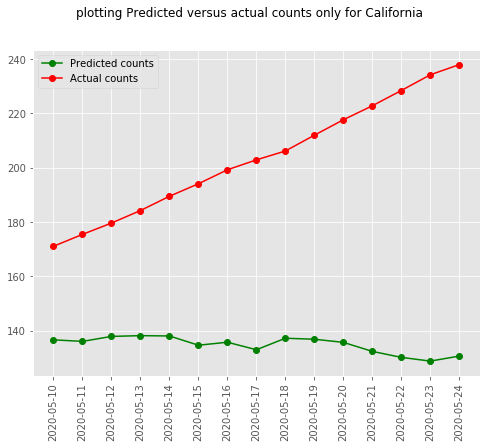

<Figure size 576x432 with 0 Axes>

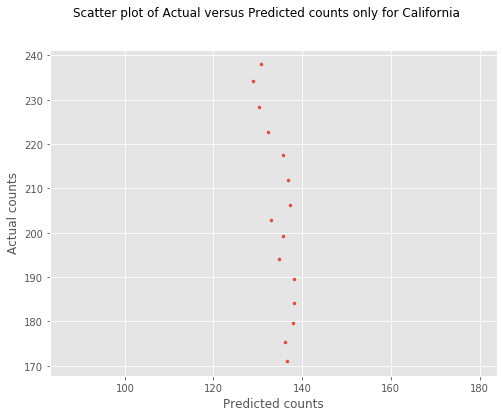

In [27]:
# on the total test dataset we find the MAE
svm.set_params(**best_grid)
svm.fit(X, y)
y_pred_test = svm.predict(Xt)
print("Mean Abosulte Error score of the best model on the whole test dataset is : %0.5f" % mean_absolute_error(y_true= yt, y_pred= y_pred_test) )

#Plot the predicted counts versus the actual counts for the test data for california.
rcParams['figure.figsize'] = 8,6
calidx = [X_te_std[:,calid] == 1 ]
fig = plt.figure()
fig.suptitle('plotting Predicted versus actual counts only for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred_test[calidx], 'go-', label='Predicted counts')
plt.xticks(test_timestamps[calidx], rotation='vertical')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts only for California')
plt.scatter(x=y_pred_test[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.axis('equal')
plt.show()

### In the SVM Regressor, the model has failed and couldn't capture the trend in the California Cases nor the Mean Absolute error on the whole test dataset is comparable.

# Poisson Regression on Generalized linear Models

In [28]:
# poisson regression from TowardsDataScience at
# https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958

#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y, X, family=sm.families.Poisson()).fit()

#Make some predictions on the test data set.
poisson_predictions = poisson_training_results.get_prediction(Xt)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

Mean Abosulte Error score on the whole test dataset is:  258.45512673619186


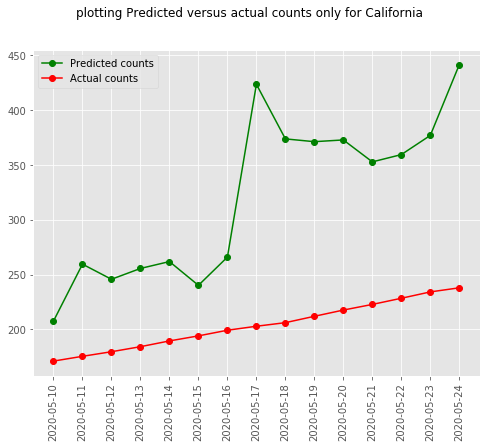

<Figure size 576x432 with 0 Axes>

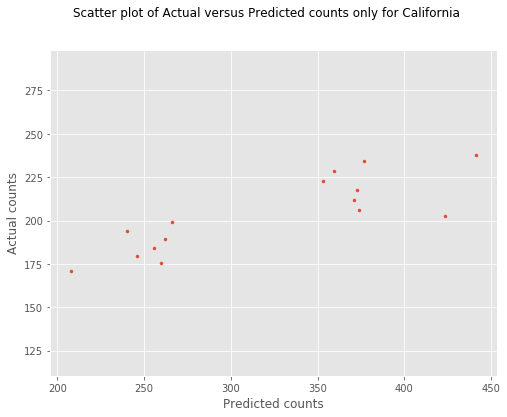

In [29]:
# on the total test dataset we find the MAE
y_pred_test = predictions_summary_frame['mean'].values
print("Mean Abosulte Error score on the whole test dataset is: ", mean_absolute_error(y_true= yt, y_pred= y_pred_test))

#Plot the predicted counts versus the actual counts for the test data for california.
rcParams['figure.figsize'] = 8,6
fig = plt.figure()
fig.suptitle('plotting Predicted versus actual counts only for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred_test[calidx], 'go-', label='Predicted counts')
plt.xticks(test_timestamps[calidx], rotation='vertical')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts only for California')
plt.scatter(x=y_pred_test[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.axis('equal')
plt.show()

### The Statsmodel's Generalized Linear Model with Poission Family could somehow capture the trend in the California Cases, however it is not smooth and the Mean Absolute Error on the whole test dataset is not very good. 

# Multi Layer Perceptron Regressor

We use the poisson loss in the MLP model, which is specially useful for the count data like the dataset that we have here.

In [30]:
batch_size = 8
num_epochs = 300
early_stop_delta = 0.5
early_stop_patience = 20


# Set of 14 different Models to have an exahstive search for the best model
models_fn = []

def mod0():
  model = Sequential()
  model.add(Dense(10, input_dim = num_features, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod0)

def mod1():
  model = Sequential()
  model.add(Dense(20, input_dim = num_features, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod1)

def mod2():
  model = Sequential()
  model.add(Dense(64, input_dim = num_features, activation='sigmoid'))
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod2)

def mod3():
  model = Sequential()
  model.add(Dense(32, input_dim = num_features, activation='sigmoid'))
  model.add(Dense(16, activation='sigmoid'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod3)

def mod4():
  model = Sequential()
  model.add(Dense(32, input_dim = num_features, activation='sigmoid'))
  model.add(Dense(16, activation='sigmoid'))
  model.add(Dense(8, activation='sigmoid'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod4)

def mod5():
  model = Sequential()
  model.add(Dense(10, input_dim = num_features, activation='sigmoid'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod5)

def mod6():
  model = Sequential()
  model.add(Dense(20, input_dim = num_features, activation='sigmoid'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod6)

def mod7():
  model = Sequential()
  model.add(Dense(64, input_dim = num_features, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod7)

def mod8():
  model = Sequential()
  model.add(Dense(32, input_dim = num_features, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod8)

def mod9():
  model = Sequential()
  model.add(Dense(32, input_dim = num_features, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod9)

def mod10():
  model = Sequential()
  model.add(Dense(32, input_dim = num_features, activation='relu'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod10)

def mod11():
  model = Sequential()
  model.add(Dense(64, input_dim = num_features, activation='sigmoid'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod11)

def mod12():
  model = Sequential()
  model.add(Dense(32, input_dim = num_features, activation='sigmoid'))
  model.add(Dense(1, activation='relu'))
  model.compile(loss='poisson', optimizer='adam', metrics= ['mae'])
  return model
models_fn.append(mod12)

In [31]:
## Training Model
# we have set up early stopping by looking at the training loss. The maximum epoch count is 300
# Unfortunately due to having a timestamped data, the crossvalidation isn't easy, so we are only training on the training set and early stop will help with not overfittig

histories= []
scores= []

best_score = np.Inf 
for model_fn in models_fn:
    # build model
    kr = None
    es = EarlyStopping(monitor= 'loss', mode='auto', min_delta= early_stop_delta, patience= early_stop_patience, verbose= 0)
    kr = KerasRegressor(build_fn= model_fn, epochs= num_epochs, batch_size= batch_size, verbose=0, shuffle= False, callbacks=[es])
    history = kr.fit(X, y)
    #save the best result with each parameter set
    #With Cross Validation
    # kfold = KFold(n_splits=CVK)
    # score = CrossValKF(model= kr, X=X, K=CVK)
    # score = CrossValLOO(model= kr, X=X)
    #no cross validation
    y_pred = kr.predict(X)
    score = mean_absolute_error(y_true= y, y_pred= y_pred)
    histories.append(history)
    scores.append(score)
    if score < best_score:
        best_score = score
        best_model_fn = model_fn
        best_history = history
        best_estimator = kr


print("Mean Abosulte Error score of the best model: %0.5f" % best_score )
print("best model function", best_model_fn)
print("best model:", best_estimator.model.summary())

Mean Abosulte Error score of the best model: 14.99621
best model function <function mod11 at 0x00000227887F6288>
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                3584      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 3,649
Trainable params: 3,649
Non-trainable params: 0
_________________________________________________________________
best model: None


### The Model 11 performed the best. This model has one hidden layer with 64 nodes and with Relu activation function. The ouput layer for all models has ReLU activation function, because the ouput count value is positive and ReLU allows for large values.

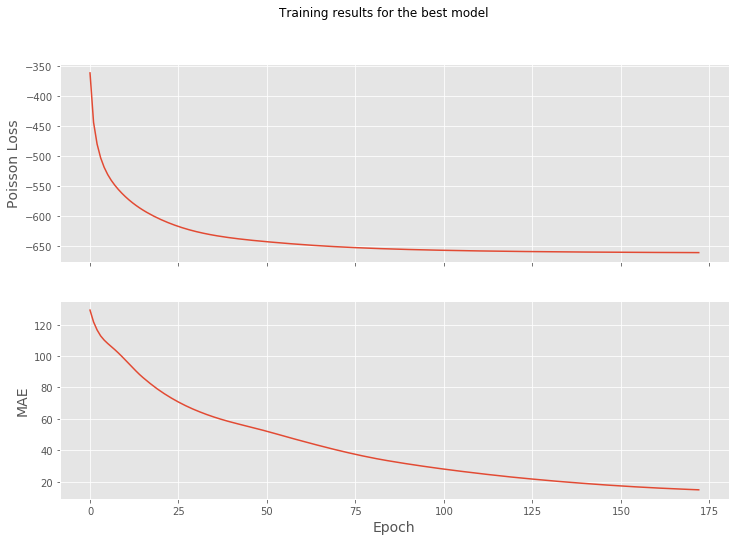

In [33]:
# training status for the best model (also we can access training statuses for each model using the "histories" list)
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training results for the best model')

axes[0].set_ylabel("Poisson Loss", fontsize=14)
axes[0].plot(best_history.history['loss'])

axes[1].set_ylabel("MAE", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(best_history.history['mae'])
plt.show()

Mean Abosulte Error score of the best model on the whole test dataset is  : 71.18555


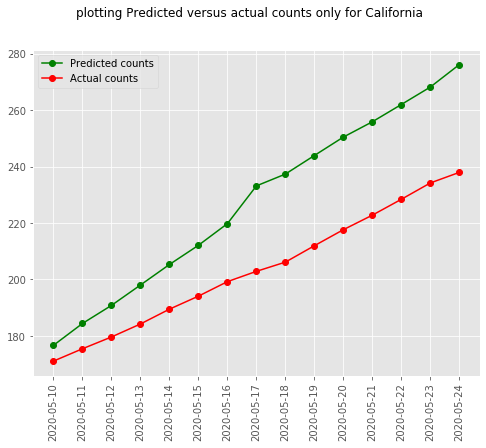

<Figure size 576x432 with 0 Axes>

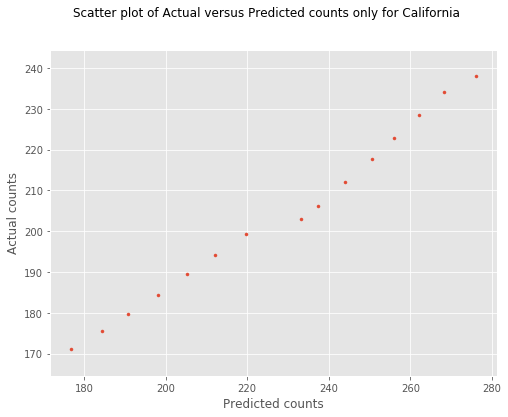

In [34]:
# on the total test dataset we find the MAE
kr = None
es = EarlyStopping(monitor= 'loss', mode='auto', min_delta= early_stop_delta, patience= early_stop_patience, verbose= 0)
kr = KerasRegressor(build_fn= best_model_fn, epochs= num_epochs, batch_size= batch_size, verbose=0, shuffle= False, callbacks=[es])
kr.fit(X, y)
y_pred_test = kr.predict(Xt)
print("Mean Abosulte Error score of the best model on the whole test dataset is  : %0.5f" % mean_absolute_error(y_true= yt, y_pred= y_pred_test) )

#Plot the predicted counts versus the actual counts for the test data for california.
rcParams['figure.figsize'] = 8,6
fig = plt.figure()
fig.suptitle('plotting Predicted versus actual counts only for California')
predicted, = plt.plot(test_timestamps[calidx], y_pred_test[calidx], 'go-', label='Predicted counts')
plt.xticks(test_timestamps[calidx], rotation='vertical')
actual, = plt.plot(test_timestamps[calidx], yt[calidx], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

#Show scatter plot of Actual versus Predicted counts
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts only for California')
plt.scatter(x=y_pred_test[calidx], y=yt[calidx], marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.axis('equal')
plt.show()

### Using the MultiLayer Perceptron Regressor, we could reach MAE of 71 on the whole test dataset, and as observable here, the trend in the California Cases is captured pretty well.